# CLUSTERING USING KMEANS

In [30]:
# Imports
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
from scripts.cleaning import clean_accounts_df 

# Load raw dataset 
df= pd.read_csv('data/accounts Data.csv')

#load clean dataset
df_clean = clean_accounts_df(df)
print(f"Cleaned data: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")

Cleaned data: 4870 rows, 14 columns


In [31]:
# Select relevant features
features = ['sector', 'referral_source', 'account_type', 'country']
#Dictionary to store encoders that will hold each LabelEncoder object for each feature to use during prediction
encoders = {}
# create a new dataframe containing only the encoded data
df_encoded = df_clean[features + ['conversion']].copy()

#Label encoding categorical features for the clusters
for col in features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])  # transform the DataFrame
    encoders[col] = le  # store the fitted encoder

In [32]:
# Split data
X = df_encoded[features]
y = df_encoded['conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
# Scale for KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_encoded['cluster'] = kmeans.fit_predict(X_scaled)

In [34]:
# Inspect cluster profiles
cluster_summary = df_encoded.groupby('cluster')[features + ['conversion']].agg(['count', 'nunique', 'mean'])
print(cluster_summary)


        sector                   referral_source                     \
         count nunique      mean           count nunique       mean   
cluster                                                               
0         1191       2  2.824517            1191      25  19.097397   
1         1148       4  1.155923            1148      26  22.059233   
2         1151       4  1.138141            1151      11  29.436142   
3         1380       4  1.246377            1380      16   4.796377   

        account_type                    country                   conversion  \
               count nunique       mean   count nunique      mean      count   
cluster                                                                        
0               1191      14  55.225861    1191       4  1.624685       1191   
1               1148      50  24.448606    1148       2  2.718641       1148   
2               1151      50  25.097307    1151       2  0.064292       1151   
3               1380  

### 1. Cluster 0 — Highest Conversion Rate (0.233)--> High Conversion Merchants
1. Can be associated with better-performing account owners and sectors.
2. Come from referral sources that are more successful
3. Can be located in countries with higher activation rates
4.  Highest conversion amongst most clusters.
5.  This is the most ideal segment for targeted campaigns. 

### 2. Cluster 1 — Below-Average Conversion (0.141986) Moderate Segment, Underperforming Merchants
1. Moderately distributed across features
2. Shows lower-than-average activation.
3. This is a stable but underperforming merchant segment.
4. Come from low performing features.
5. This cluster is more concentrated in low-value, low-engagement categories.
   
### 3. Cluster 2 — Moderate Conversion (0.177237)--> Moderate Activation Merchants
1. Come from moderate-performing countries
2. Come from referral sources that produce lower activation
3. Belong to similar, middle-value sectors.
   
### 4. Cluster 3 —Medium Conversion (0.173913)--> Mixed Segment Merchants
1. the most diverse group
2. represents merchants from many sectors, countries, referral sources
3. performs average in conversions
   

In [35]:
cluster_profiles = {}

for col in features:
    cluster_profiles[col] = (
        df_encoded.groupby('cluster')[col]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

cluster_profiles['conversion'] = (
    df_encoded.groupby('cluster')['conversion']
    .mean()
    .reset_index()
)

In [36]:
summary = {}

for feature, df in cluster_profiles.items():
    if feature == "conversion":
        continue
    
    le = encoders[feature]  # get the label encoder for this feature
    
    # Map encoded values back to original names
    df = df.copy()
    df[feature] = le.inverse_transform(df[feature].astype(int))
    
    # For each feature, get top categories by proportion per cluster
    top = (
        df.sort_values(["cluster", "proportion"], ascending=[True, False])
          .groupby("cluster")
          .head(3)   # top 3 categories
    )
    
    summary[feature] = top

summary["conversion"] = cluster_profiles["conversion"]

# Print clean human-readable results
for key, value in summary.items():
    print(f"\n{key.upper()}")
    print(value)



SECTOR
    cluster       sector  proportion
0         0       Travel    0.824517
1         0       Retail    0.175483
2         1       Retail    0.378049
3         1  Hospitality    0.365854
4         1   E-Commerce    0.244774
6         2  Hospitality    0.409209
7         2       Retail    0.347524
8         2   E-Commerce    0.231972
10        3       Retail    0.423913
11        3  Hospitality    0.346377
12        3   E-Commerce    0.212319

REFERRAL_SOURCE
    cluster              referral_source  proportion
0         0                  Self Search    0.502099
1         0  Account Management Referral    0.150294
2         0                Bank Referral    0.082284
25        1                  Self Search    0.570557
26        1                Bank Referral    0.094077
27        1                     Helpdesk    0.060105
51        2                  Self Search    0.857515
52        2                 Web Research    0.056473
53        2                 Social Media    0.039965
6

### Cluster 0
* A strong travel and tourism cluster, specifically Tour Operators and Travel Agents, discovering the product through self-search.
* This cluster has the highest conversion, therefore ideal segment for targeted campaigns.

### cluster 1
* This cluster is dominated by bank referrals from Uganda.
* Retail and hospitality presence is strong, but conversion is the lowest, indicates low interest or mismatched targeting.

### cluster 2
* Primarily Kenyan-based, with strong hospitality and e-commerce presence.
* Bank referrals still play a role, but lighter research-based traffic exists.
* Moderate conversion.

### cluster 3
* Highly Kenyan, strong in E-Commerce and Hospitality, and mostly coming via managed referrals and service chats.
* Conversion is average.

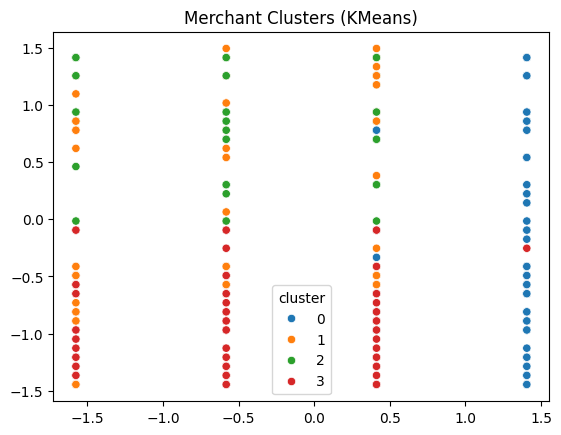

In [37]:
"""
# PCA for Visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_encoded['PC1'] = X_pca[:, 0]
df_encoded['PC2'] = X_pca[:, 1]

# PCA-based centroids for plotting
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x='PC1', y='PC2', hue='cluster', palette='tab10',s=40,alpha=0.8)

# Add centroids 
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='black', marker='X', label='Centroids')

plt.title('KMeans Merchant Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
"""
 #Visualize clusters
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df_encoded['cluster'], palette='tab10')
plt.title('Merchant Clusters (KMeans)')
plt.show()


### Dimensionality Reduction with centroids using PCA to visualize the clusters.

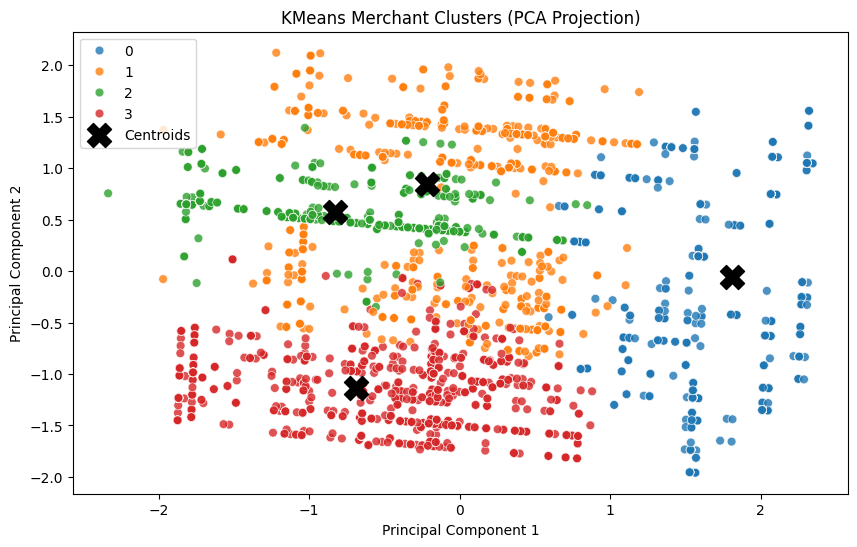

In [38]:
# PCA for Visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_encoded['PC1'] = X_pca[:, 0]
df_encoded['PC2'] = X_pca[:, 1]

# PCA-based centroids for plotting
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x='PC1', y='PC2', hue='cluster', palette='tab10',s=40,alpha=0.8)

# Add centroids 
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='black', marker='X', label='Centroids')

plt.title('KMeans Merchant Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Visual Interpretation (PCA Projection)
The KMeans Merchant Clusters (PCA Projection) plot effectively visualizes the separation:
1. Cluster 0 (Blue): Tightly clustered on the far right of PC1 (High PC1 value), suggests more variability among those merchants.
2. Cluster 3 (Red): Clustered mostly on the bottom-left (Negative PC1 and PC2 values), indicating its diverse but separate nature.
3. Clusters 1 (Orange) and 2 (Green): These two clusters are overlapping in the center-left/top-center of the plot, which visually aligns with their similar, moderate conversion rates and shared features, making them less distinct in the reduced 2D space.

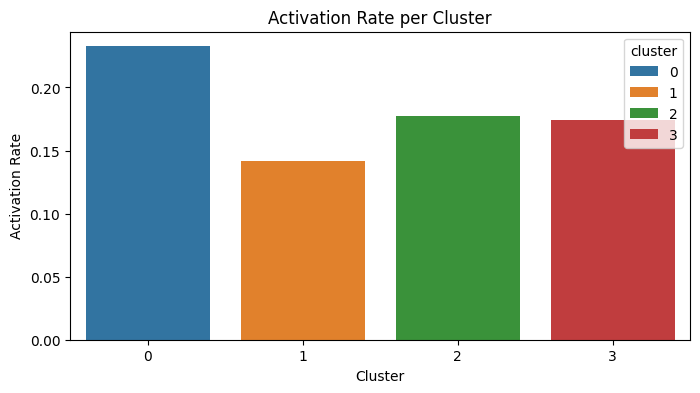

In [10]:
# Activation rate per cluster
activation_rate = df_encoded.groupby('cluster')['conversion'].mean()
cluster_sizes = df_encoded['cluster'].value_counts().sort_index()

#Activation Rate Bar Chart
plt.figure(figsize=(8, 4))
sns.barplot(x=activation_rate.index, y=activation_rate.values, palette='tab10' ,  hue=cluster_sizes.index,)
plt.title('Activation Rate per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Activation Rate')
plt.show()


1. Cluster 0 has the highest activation rate while cluster 1 has the lowest.
2. Clusters 2 annd 3 have moderate activation rates

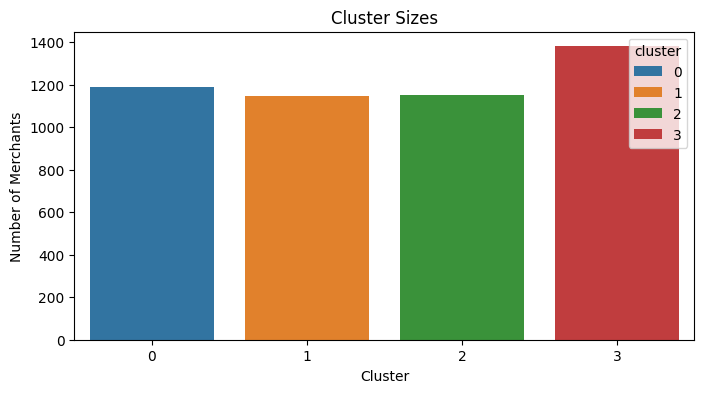

In [11]:
# Cluster Size Bar Chart
plt.figure(figsize=(8, 4))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='tab10', hue=cluster_sizes.index,)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Merchants')
plt.show()


### Cluster 0: High converters and medium number of merchants
### Cluster 1 and 2 : Lowest clusters
### Cluster 3: Largest cluster

In [12]:
import joblib
joblib.dump(encoders, 'encoders.joblib')


['encoders.joblib']

In [13]:
# After training KMeans and having the original df_clean with 'conversion'
df_clean['cluster'] = kmeans.predict(X_scaled)

cluster_activation_map = (
    df_clean.groupby('cluster')['conversion']
    .mean()
    .to_dict()
)

# Save the map
joblib.dump(cluster_activation_map, "cluster_map.joblib")


['cluster_map.joblib']

In [14]:
# save decision tree model
joblib.dump(kmeans, "kmeans_model.joblib")


['kmeans_model.joblib']